In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
df=pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head()
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [99]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [23]:
print(df.isnull().sum())

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [73]:
df_filled = df.copy()

for c in df_filled.columns:
    if df_filled[c].dtype == 'object':
        converted = pd.to_numeric(df_filled[c], errors='coerce')
        if converted.notna().mean() > 0.9:
            df_filled[c] = converted.fillna(0.0)
        else:
            df_filled[c] = df_filled[c].fillna('NA')
    else:
        df_filled[c] = df_filled[c].fillna(0.0)

print(df.isnull().sum())

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [72]:
df_full_train, df_test = train_test_split(df_filled, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

for part in (df_train, df_val, df_test):
    part.reset_index(drop=True, inplace=True)


num_cols = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']


for c in num_cols:
    df_train[c] = pd.to_numeric(df_train[c], errors='coerce').fillna(0.0)
    df_val[c]   = pd.to_numeric(df_val[c], errors='coerce').fillna(0.0)
    df_test[c]  = pd.to_numeric(df_test[c], errors='coerce').fillna(0.0)


y_train = df_train['converted'].astype(int).values
y_val   = df_val['converted'].astype(int).values
y_test  = df_test['converted'].astype(int).values

print(df_train[num_cols].dtypes)

lead_score                  float64
number_of_courses_viewed      int64
interaction_count             int64
annual_income               float64
dtype: object


In [74]:
num_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

      
for v in num_vars:
    auc = roc_auc_score(y_train, df_train[v])  
    if auc < 0.5:                             
        auc = roc_auc_score(y_train, -df_train[v]) 
    print(v, round(auc, 3))  

lead_score 0.614
number_of_courses_viewed 0.764
interaction_count 0.738
annual_income 0.552


In [76]:
drop_cols = ['converted']
train_dicts = df_train.drop(columns=drop_cols).to_dict(orient='records')
val_dicts   = df_val.drop(columns=drop_cols).to_dict(orient='records')
print(df_train[['lead_source','industry','employment_status','location']].dtypes)

lead_source          object
industry             object
employment_status    object
location             object
dtype: object


In [82]:
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val   = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)


y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(round(auc, 3))
print(len(dv.get_feature_names_out()))

0.817
31


In [80]:
print(df_train.columns)

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')


In [81]:
print(df_train[['lead_source','industry','employment_status','location']].head(10))

      lead_source       industry employment_status       location
0          events  manufacturing        unemployed         europe
1        referral             NA           student  south_america
2  organic_search     healthcare        unemployed         europe
3        paid_ads          other          employed  south_america
4        paid_ads      education        unemployed  south_america
5        referral  manufacturing           student             NA
6        paid_ads          other           student    middle_east
7    social_media     healthcare        unemployed  south_america
8  organic_search             NA        unemployed      australia
9  organic_search         retail        unemployed  south_america


In [83]:
for c in ['lead_source','industry','employment_status','location']:
    print(c, df_train[c].nunique())

lead_source 6
industry 8
employment_status 5
location 8


In [84]:
print(df_train[['lead_score','number_of_courses_viewed','interaction_count','annual_income']].dtypes)

lead_score                  float64
number_of_courses_viewed      int64
interaction_count             int64
annual_income               float64
dtype: object


In [100]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
ths = np.linspace(0, y_pred.max(), 100)
precisions, recalls = [], []

for t in ths:
    y_hat = (y_pred >= t).astype(int)
    p = precision_score(y_val, y_hat, zero_division=0)
    r = recall_score(y_val, y_hat, zero_division=0)
    precisions.append(p)
    recalls.append(r)

precisions = np.array(precisions)
recalls = np.array(recalls)


idx = np.argmin(np.abs(precisions - recalls))
t_star = float(ths[idx])

print(f"Threshold where Precision ≈ Recall: {t_star:.3f}")
print(f"Precision at that point: {precisions[idx]:.3f}")
print(f"Recall at that point: {recalls[idx]:.3f}")


Threshold where Precision ≈ Recall: 0.639
Precision at that point: 0.775
Recall at that point: 0.784


In [95]:
print(y_pred.min(), y_pred.max())

0.2620088894928918 0.9729565475181032


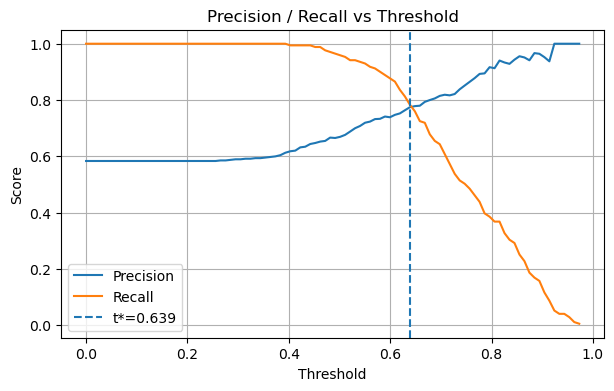

In [97]:
plt.figure(figsize=(7,4))
plt.plot(ths, precisions, label="Precision")
plt.plot(ths, recalls, label="Recall")
plt.axvline(t_star, linestyle="--", label=f"t*={t_star:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [101]:
den = precisions + recalls
f1s = np.where(den > 0, 2 * precisions * recalls / den, 0.0)

best_idx = int(np.argmax(f1s))
best_t = float(ths[best_idx])
best_f1 = float(f1s[best_idx])


print(f"Threshold where F1 is maximal: {best_t:.3f}")
print(f"Best F1 score: {best_f1:.3f}")



Threshold where F1 is maximal: 0.570
Best F1 score: 0.812


In [104]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

def ready(df):
    y = df['converted'].astype(int).values
    dicts = df.drop(columns=['converted']).to_dict(orient='records')
    return dicts, y
    
for tr_idx, va_idx in kf.split(df_full_train):
    tr_dicts, y_tr = ready(df_full_train.iloc[tr_idx])
    va_dicts, y_va = ready(df_full_train.iloc[va_idx])

    dv = DictVectorizer(sparse=True)
    X_tr = dv.fit_transform(tr_dicts)
    X_va = dv.transform(va_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model.fit(X_tr, y_tr)

    y_pred = model.predict_proba(X_va)[:, 1]
    scores.append(roc_auc_score(y_va, y_pred))

print("Fold AUCs:", [round(s, 3) for s in scores])
print("Mean AUC:", round(np.mean(scores), 3))
print("Std AUC:",  round(np.std(scores), 3))

Fold AUCs: [np.float64(0.806), np.float64(0.871), np.float64(0.775), np.float64(0.802), np.float64(0.856)]
Mean AUC: 0.822
Std AUC: 0.036


In [106]:
Cs = [1e-6, 1e-3, 1.0]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

def cv_auc_for(C):
    scores = []
    for tr_idx, va_idx in kf.split(df_full_train):
        tr_dicts, y_tr = ready(df_full_train.iloc[tr_idx])
        va_dicts, y_va = ready(df_full_train.iloc[va_idx])

        dv = DictVectorizer(sparse=True)
        X_tr = dv.fit_transform(tr_dicts)
        X_va = dv.transform(va_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
        model.fit(X_tr, y_tr)

        y_pred = model.predict_proba(X_va)[:, 1]
        scores.append(roc_auc_score(y_va, y_pred))
    return float(np.mean(scores)), float(np.std(scores))

results = []
for C in Cs:
    mean_auc, std_auc = cv_auc_for(C)
    results.append((C, round(mean_auc, 3), round(std_auc, 3)))


print("C, mean_auc, std_auc")
for C, m, s in results:
    print(C, m, s)

best = sorted(results, key=lambda x: (-x[1], x[2], x[0]))[0]
print("\nBest C:", best[0], "| mean_auc:", best[1], "| std_auc:", best[2])

C, mean_auc, std_auc
1e-06 0.56 0.024
0.001 0.867 0.029
1.0 0.822 0.036

Best C: 0.001 | mean_auc: 0.867 | std_auc: 0.029
